In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import  metrics
from matplotlib.colors import colorConverter, ListedColormap
import itertools
import collections
import math
import csv

np.random.seed(seed=1)
%matplotlib inline

In [2]:
def to_onehot_vec(data, shape):
    Y = np.zeros(shape=shape, dtype=int)
    Y[data, np.arange(data.size)] = 1
    return Y

def print_biases(filename, biases):
    with open(filename,"w") as f:
        f.write("\n".join(",".join(map(str, x)) for x in biases))

def print_weights(filename, weights):
    with open(filename, "w") as f:
        writer = csv.writer(f)
        for w in weights:
            writer.writerows(w)
            
def ReLU(x): 
    #return np.maximum(0.01*x, x)
    return x * (x > 0)

def dReLU(x):
#     return 1. * (x > 0) + 0.01 * (x<0) 
    return 1. * (x > 0)
    
def softmax(x): 
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis=1, keepdims = True)

In [3]:
# Define the layers used in this model
class Layer(object):

    def get_params_iter(self):
        return []
    
    def get_params_grad(self, X, output_grad):
        return []
    
    def get_output(self, X):
        pass
    
    def get_input_grad(self, Y, output_grad=None, T=None):
        pass

In [4]:
class LinearLayer(Layer):

    def __init__(self, W, b):
        self.W= W
        self.b = b
        
    def get_params_iter(self):
        return itertools.chain(np.nditer(self.W, op_flags=['readwrite']), np.nditer(self.b, op_flags=['readwrite']))
    
    def get_output(self, X):
        return X.dot(self.W) + self.b
        
    def get_params_grad(self, X, output_grad):
        JW = np.float32(X.T.dot(output_grad))
        Jb = np.float32(np.sum(output_grad, axis=0))
        
        if testing_gradient:
            global dW_test
            global db_test
            dW_test.append(JW)
            db_test.append(Jb)
        
        return [g for g in itertools.chain(np.nditer(JW), np.nditer(Jb))]
    
    def get_input_grad(self, Y, output_grad):
        return output_grad.dot(self.W.T)

In [5]:
class ReLULayer(Layer):
    
    def get_output(self, X):
        return ReLU(X)
    
    def get_input_grad(self, Y, output_grad):
        return np.multiply(dReLU(Y), output_grad)

In [6]:
class SoftmaxOutputLayer(Layer):
    
    def get_output(self, X):
        return softmax(X)
    
    def get_input_grad(self, Y, T):
        return (Y - T) / Y.shape[0]
    
    def get_cost(self, Y, T):
        return - np.multiply(T, np.log(Y)).sum() / Y.shape[0]

In [7]:
X = np.loadtxt(fname = "Question2_123/x_train.csv", dtype=int, delimiter=',', unpack=True)
m = X.shape[1]
split = math.ceil(0.7 * m)

X_validation = X [:, split: ]
X_train = X [:, : split]
X_test= np.loadtxt(fname = "Question2_123/x_test.csv", dtype=int, delimiter=',', unpack=True)

data = np.loadtxt(fname = "Question2_123/y_train.csv", dtype=int, delimiter=',')
Y = to_onehot_vec(data, (4, m))

T_validation = Y [:, split: ]
T_train = Y [:, : split]
data = np.loadtxt(fname = "Question2_123/y_test.csv", dtype=int, delimiter=',')
T_test = to_onehot_vec(data, (4, X_test.shape[1]))

X_validation = X_validation.T
X_train = X_train.T
X_test = X_test.T

T_validation = T_validation.T
T_train = T_train.T
T_test = T_test.T

testing_gradient = False
if testing_gradient:
    multiplier = 1
else:
    multiplier = .4
    
biases = np.genfromtxt(fname = 'Question2_4/c/b-14-28-4.csv', delimiter=',')
b = [ ]
for i in range(28):
    b.append(biases[i][:14] * multiplier)
b.append(biases[28][:4] * multiplier)

w = [ ]
weights = np.genfromtxt(fname = 'Question2_4/c/w-14-28-4.csv', delimiter=',')
for i in range(28):
    start = i*14
    end = start + 14
    w.append(weights[start:end,:14] * multiplier)
w.append(weights[14*28:,:4] * multiplier)

# Use random weights and biases

# b = [ ]
# for i in range(28):
#     b.append(np.zeros(14))
# b.append(np.zeros(4))

# w = [ ]
# for i in range(28):
#     w.append(np.random.randn(14, 14) * .25)
# w.append(np.random.randn(14, 4) * .25)

In [8]:
# Create the model
layers = [] # Define a list of layers

layers.append(LinearLayer(w[0],b[0]))
layers.append(ReLULayer())

for i in range(27):
    layers.append(LinearLayer(w[i+1],b[i+1]))
    layers.append(ReLULayer())

layers.append(LinearLayer(w[28],b[28]))
layers.append(SoftmaxOutputLayer())

In [9]:
def forward_step(input_samples, layers):
    activations = [input_samples]
    X = input_samples
    for layer in layers:
        Y = layer.get_output(X) 
        activations.append(Y)
        X = activations[-1]
    return activations

In [10]:
def backward_step(activations, targets, layers):
    param_grads = collections.deque() 
    output_grad = None
    
    for layer in reversed(layers):   
        Y = activations.pop()
        
        if output_grad is None:
            input_grad = np.float32(layer.get_input_grad(Y, targets))
        else:
            input_grad = layer.get_input_grad(Y, output_grad)

        X = activations[-1]
        grads = layer.get_params_grad(X, output_grad)
        param_grads.appendleft(grads)
        output_grad = input_grad
    return list(param_grads)

In [11]:
# Perform gradient checking
dW_test = [ ]
db_test = [ ]

X_temp= np.reshape([-1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1],  (1, 14))
T_temp= np.reshape([0,0,0,1],  (1, 4))
activations = forward_step(X_temp, layers)
param_grads = backward_step(activations, T_temp, layers)

# Set the small change to compute the numerical gradient
eps = 0.0001
# Compute the numerical gradients of the parameters in all layers.
for idx in range(len(layers)):
    layer = layers[idx]
    layer_backprop_grads = param_grads[idx]
    # Compute the numerical gradient for each parameter in the layer
    for p_idx, param in enumerate(layer.get_params_iter()):
        grad_backprop = layer_backprop_grads[p_idx]
        # + eps
        param += eps
        plus_cost = layers[-1].get_cost(forward_step(X_temp, layers)[-1],  T_temp)
        # - eps
        param -= 2 * eps
        min_cost = layers[-1].get_cost(forward_step(X_temp, layers)[-1], T_temp)
        # reset param value
        param += eps
        # calculate numerical gradient
        grad_num = (plus_cost - min_cost)/(2*eps)

if testing_gradient:
    print_weights("output/dw-14-28-4.csv", dW_test[::-1])
    print_biases("output/db-14-28-4.csv", db_test[::-1])
testing_gradient = False

In [12]:
batch_size = 25
nb_of_batches = X_train.shape[0] / batch_size
XT_batches = list(zip(
    np.array_split(X_train, nb_of_batches, axis=0),
    np.array_split(T_train, nb_of_batches, axis=0))) 

In [13]:
def update_params(layers, param_grads, learning_rate):
    for layer, layer_backprop_grads in list(zip(layers, param_grads)):
        for param, grad in zip(layer.get_params_iter(), layer_backprop_grads):
            param -= learning_rate * grad  # Update each parameter in place

In [14]:
# Perform backpropagation

minibatch_costs = []
training_costs = []
validation_costs = []
test_costs = []

train_accuracy_arr = []
test_accuracy_arr = []

max_nb_of_iterations = 200
learning_rate = .05

y_true_train = np.argmax(T_train, axis=1) 
y_true_test = np.argmax(T_test, axis=1) 

for iteration in range(max_nb_of_iterations):
    
    if iteration%(max_nb_of_iterations/10) == 0:
        pc = iteration/(max_nb_of_iterations/10) * 10
        print('{}% completed'.format(pc))
        
#     if iteration > 10:
#         learning_rate = .05
        
#     if iteration > 10:
#         learning_rate = .045

#     if iteration > 20:
#         learning_rate = .04
        
#     if iteration > 40:
#         learning_rate = .035
    
    for X, T in XT_batches:
        activations = forward_step(X, layers)
        minibatch_cost = layers[-1].get_cost(activations[-1], T)
        minibatch_costs.append(minibatch_cost)
        param_grads = backward_step(activations, T, layers)
        update_params(layers, param_grads, learning_rate)
    
    # Store training cost
    activations = forward_step(X_train, layers)
    train_cost = layers[-1].get_cost(activations[-1], T_train)
    training_costs.append(train_cost)
    
    # Store training accuracy
    y_pred = np.argmax(activations[-1], axis=1)
    train_accuracy_arr.append(metrics.accuracy_score(y_true_train, y_pred))
    
    # Store validation cost
    activations = forward_step(X_validation, layers)
    validation_cost = layers[-1].get_cost(activations[-1], T_validation)
    validation_costs.append(validation_cost)
    
    # Store test cost
    activations = forward_step(X_test, layers)
    test_cost = layers[-1].get_cost(activations[-1], T_test)
    test_costs.append(test_cost)
    
    # Store test accuracy
    y_pred = np.argmax(activations[-1], axis=1)
    test_accuracy_arr.append(metrics.accuracy_score(y_true_test, y_pred))
        
#     if len(validation_costs) > 50 and validation_costs[-1] >= validation_costs[-2] >= validation_costs[-3]:
#         print("Validation cost has not decreased for 3 epoches: " + str(iteration))
#         break
            
nb_of_iterations = iteration + 1  # The number of iterations that have been executed
print('100% completed')

0.0% completed
10.0% completed
20.0% completed
30.0% completed
40.0% completed
50.0% completed
60.0% completed
70.0% completed
80.0% completed
90.0% completed
100% completed


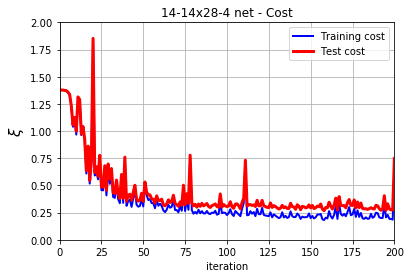

In [15]:
# Plot the costs over the iterations
iteration_x_inds = np.linspace(1, nb_of_iterations, num=nb_of_iterations)
plt.plot(iteration_x_inds, training_costs, 'b-', linewidth=2, label='Training cost')
plt.plot(iteration_x_inds, test_costs, 'r-', linewidth=3, label='Test cost')

plt.xlabel('iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('14-14x28-4 net - Cost')
plt.legend()
x1,x2,y1,y2 = plt.axis()
plt.axis((0,nb_of_iterations,0,2))
plt.grid()
plt.show()

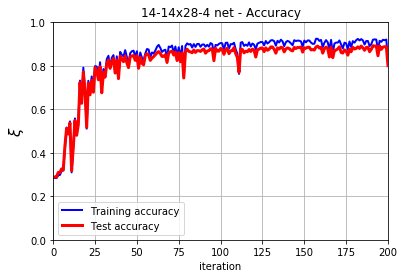

In [16]:
# Plot the costs over the iterations
iteration_x_inds = np.linspace(1, nb_of_iterations, num=nb_of_iterations)
plt.plot(iteration_x_inds, train_accuracy_arr, 'b-', linewidth=2, label='Training accuracy')
plt.plot(iteration_x_inds, test_accuracy_arr, 'r-', linewidth=3, label='Test accuracy')

plt.xlabel('iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('14-14x28-4 net - Accuracy')
plt.legend()
x1,x2,y1,y2 = plt.axis()
plt.axis((0,nb_of_iterations,0,1))
plt.grid()
plt.show()

In [23]:
# Store training cost
n = 1
training_costs_m = []
validation_costs_m = []
test_costs_m = []

max_m = X_validation.shape[0]
count = 0
while n < max_m:
    activations = forward_step(X_train[:n, :], layers)
    training_costs_m.append(layers[-1].get_cost(activations[-1], T_train[:n, :]))
    
    activations = forward_step(X_validation[:n, :], layers)
    validation_costs_m.append(layers[-1].get_cost(activations[-1], T_validation[:n, :]))
    
    activations = forward_step(X_test[:n, :], layers)
    test_costs_m.append(layers[-1].get_cost(activations[-1], T_test[:n, :]))

    n = n + 1;
    count +=1

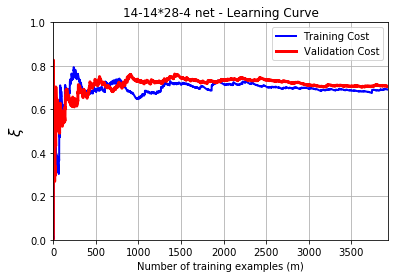

In [26]:
iteration_x_inds = np.linspace(1, count, num=count)
plt.plot(iteration_x_inds, training_costs_m, 'b-', linewidth=2, label='Training Cost')
plt.plot(iteration_x_inds, validation_costs_m, 'r-', linewidth=3, label='Validation Cost')
#plt.plot(iteration_x_inds, test_costs_m, 'k-', linewidth=3, label='Test Cost')

plt.xlabel('Number of training examples (m)')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('14-14*28-4 net - Learning Curve')
plt.legend()
x1,x2,y1,y2 = plt.axis()
plt.axis((0,count,0,1))
plt.grid()
plt.show()